In [1]:
import matplotlib as m
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter, sobel
from scipy.optimize import curve_fit
from scipy import signal
from skimage import io
import os
from skimage import data
import imageio

# Import

In [1]:
#Import background
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP')
os.chdir(r'Data\Control\drive-download-20220317T085515Z-001\well9_561nm_OD2_POPC(c)_1')
filename_bg = 'well9_561nm_OD2_POPC(c)_1_MMStack_Pos0.ome.tif'
bg = io.imread(filename_bg)

os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP')
os.chdir(r'Data\Control\drive-download-20220317T085515Z-001\well10_561nm_OD2_POPC(c)_1')
filename_bg2 = 'well10_561nm_OD2_POPC(c)_1_MMStack_Pos0.ome.tif'

bg2 = io.imread(filename_bg2)

background = np.mean(np.concatenate((bg,bg2))) # find the average background counts
background= background.astype(float)

filename = 'well2_slide2_561nm_OD1p6_Ni(2)-TMR_0p5mgmL_Epi_1'
#Import gaussian df
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP\Data\2022_03_17\2022_03_17_SLB_TR\plottable\2/' +filename)
gaussian_filename = filename+'2D gaussian.csv'

df_gauss = pd.read_csv(gaussian_filename)
df_gauss=df_gauss.set_index('Unnamed: 0')

#Import image
#post
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP\Data\2022_03_17\2022_03_17_SLB_TR\plottable\2/'+filename+'/post')
filename_post = 'cropped '+filename+'_MMStack_Pos0.ome.tif'
im_post = io.imread(filename_post)
#pre
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP\Data\2022_03_17\2022_03_17_SLB_TR\plottable\2/'+filename+'/pre')
filename_pre = 'cropped '+filename+'_MMStack_Pos0.ome.tif'
im_pre = io.imread(filename_pre)


im_post = im_post.astype(float) #Convert the entries in each array to floats
im_pre = im_pre.astype(float) #Convert the entries in each array to floats

im_post = im_post-background #Correct for bg counts
im_pre = im_pre-background #Correct for bg counts

print(np.shape(im_post))
print(np.shape(im_pre))

NameError: name 'os' is not defined

# Take the pre from the post to find the bleached spot

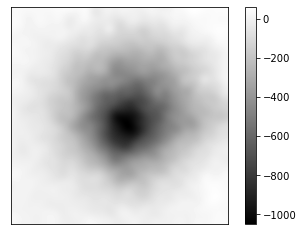

In [3]:
spot = im_post[0]-im_pre[-1] #take the last image from pre from the first image post- only left with the spot (negative values)
spot= gaussian_filter(spot,sigma=10) #gaussian blur


fig, ax= plt.subplots()
plot=ax.imshow(spot,cmap=plt.cm.gray)
cb=fig.colorbar(plot)
ax.set_xticks([])
ax.set_yticks([])
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP')
#plt.savefig('spot_exclusion.png',dpi=600)

# Set a limit and find the spot

In [4]:
limit = np.mean(spot)*2  #set a thershold of all values a 2 over the mean value (this will be negative)
spot_df= pd.DataFrame(data=np.empty((512, 1)),columns={'Col'},dtype=object)
for i in range(512):
        spot_index = [idx for idx, val in enumerate(spot[i,:]) if val < limit] #Get index of values that are below the limit
        spot_df.loc[i,'Col'] = spot_index
print(spot_df)
spot_df=spot_df[spot_df['Col'].map(lambda d: len(d)) > 0] #Remove empty lists
print(spot_df)

    Col
0    []
1    []
2    []
3    []
4    []
..   ..
507  []
508  []
509  []
510  []
511  []

[512 rows x 1 columns]
                                                   Col
123  [250, 251, 252, 253, 254, 255, 256, 257, 258, ...
124  [246, 247, 248, 249, 250, 251, 252, 253, 254, ...
125  [244, 245, 246, 247, 248, 249, 250, 251, 252, ...
126  [241, 242, 243, 244, 245, 246, 247, 248, 249, ...
127  [240, 241, 242, 243, 244, 245, 246, 247, 248, ...
..                                                 ...
389  [259, 260, 261, 262, 263, 264, 265, 266, 267, ...
390  [260, 261, 262, 263, 264, 265, 266, 267, 268, ...
391  [262, 263, 264, 265, 266, 267, 268, 269, 270, ...
392  [263, 264, 265, 266, 267, 268, 269, 270, 271, ...
393  [266, 267, 268, 269, 270, 271, 272, 273, 274, ...

[271 rows x 1 columns]


259
290


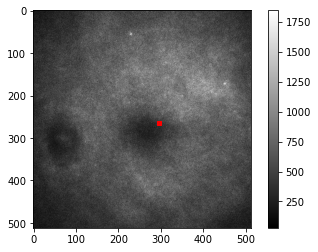

In [5]:
fig, ax= plt.subplots()
center_y =spot_df.index[round((len(spot_df)/2))]
print(center_y)
center_x = spot_df['Col'][center_y][round(len(spot_df['Col'][center_y])/2)]
print(center_x)
rect = plt.Rectangle((center_x, center_y), 10, 10,color='r')
plot= ax.imshow(im_post[0],cmap=plt.cm.gray)
fig.colorbar(plot)
ax.add_patch(rect)
plt.show()

# Correct for uneven illumination

Take the mean of the pre bleach images

In [6]:
mean_pre = np.empty((512,512))  #create an empty array for the averaged pre image
for j in range(len(im_pre[1])): #Iterate over all rows
    for i in range(len(im_pre[2])): #Iterate over all columns
        mean_pre[i][j] = np.mean(im_pre[:,i,j]) #Calculate the average of each pixel and set the value of the mean array

Divide all the images post and pre bleach by the pre bleach average (normalise the data to the pre-bleach images)

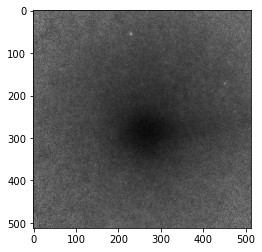

In [7]:
for i in range(len(im_post[:,0,0])): # Divide all images after bleach by the pre bleach average
    im_post[i]= im_post[i]/mean_pre
    
    
    
for i in range(len(im_pre[:,0,0])): # Divide all images pre bleach by the pre bleach average
    im_pre[i]= im_pre[i]/mean_pre
    
fig, ax= plt.subplots()
ax.imshow(im_post[0],cmap=plt.cm.gray)
plt.show()

# Find temporal fluctuations function from reference area

In [8]:
limit = np.mean(spot) #set a thershold of all values a over the mean value, spot= (first postbleach-last pre bleach)
## Only find the reference area once
reference_df= pd.DataFrame(data=np.empty((512, 2)),columns={'Col', 'Ave_Col'},dtype=object) # Create an empty df
for i in range(512):
        reference_index = [idx for idx, val in enumerate(spot[i,:]) if val > limit] #Get index of values that are above the limit(mean)
        reference_df.loc[i,'Col'] = reference_index
reference_df=reference_df[reference_df['Col'].map(lambda d: len(d)) > 0] #Remove empty lists- should'nt be any in this case

temporal_array= np.empty((1,len(im_post))) #Create an array to put the temporal change data in

for j in range(len(im_post)):
    ## Calculate the average intensity at each 
    ref_array= np.empty((1,512))
    for i in range(len(reference_df['Col'])): #Iterate over all the rows
        ref_array[:,i]= np.mean(im_post[j][reference_df.index[i]]) #Calculate the mean at each row for each column
    ave_ref_int =  np.mean(ref_array)# calculate the mean at each column (all the reference pixels)
    temporal_array[:,j]= ave_ref_int
    print(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247


# Fit an exponential decay to the temporal fluctuations

In [9]:
x=np.array([i for i in range(len(im_post))])
def func(x,a,b):
    return (a*(np.exp(-x/b)))
popt, pcov = curve_fit(func, x, temporal_array[0,:], maxfev=100000000)#, p0=[13000,4000000,-1300])#, method='lm')
print(popt)
print(pcov)
perr_sd = np.sqrt(np.diag(pcov))
print(perr_sd)

[8.89125183e-01 3.92458259e+03]
[[ 6.31421216e-07 -6.69998093e-02]
 [-6.69998093e-02  9.60060793e+03]]
[7.94620171e-04 9.79826920e+01]


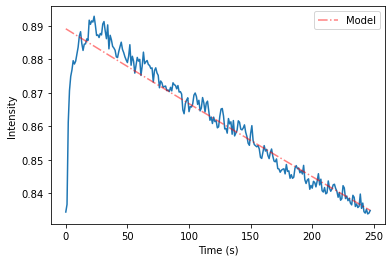

In [12]:
a, b = popt
fig, ax= plt.subplots()
ax.plot(x,temporal_array[0,:])
ax.plot(x, func(x,*popt),alpha =0.5,linestyle='dashdot',color='red', label= 'Model')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Intensity')
ax.legend()
plt.savefig('temporal correction.png',dpi=600)

# Correct data for temporal variations

In [11]:
for i in range(len(im_post[:,0,0])): # Divide all images after bleach by function which gives the amount photofaded
    im_post[i]= im_post[i]/func(i,a,b)

# Use 2D fitted gaussian to make nice figure

In [12]:
df_gauss

,x0,y0,Depth,Re,Intensity at Re=sd,Time (s)
Unnamed: 0,,,,,,
0,275.024367,268.170461,0.990745,149.956073,0.874518,0.000
1,271.433948,261.027326,0.845334,141.612068,0.891898,0.328
2,271.575156,285.809233,0.870652,106.391725,0.888847,0.643
3,271.574977,286.359144,0.833710,102.422911,0.893302,0.968
4,271.590677,285.906690,0.791369,103.653790,0.898436,1.317
...,...,...,...,...,...,...
243,275.584815,262.101392,0.083293,-158.366499,0.988791,81.010
244,279.880582,260.235983,0.086763,-154.763432,0.988327,81.339
245,279.383014,258.603421,0.089643,-154.232673,0.987941,81.656


# Make a figure that shows recovery

C:\Users\tselb\AppData\Local\Temp/ipykernel_16860/675590988.py:43: UserWarning: The following kwargs were not used by contour: 'zlim'
  fitted_exp_gauss_contor=ax.contour(X,Y,Z,cmap='magma',zlim=(0,1), levels=4)


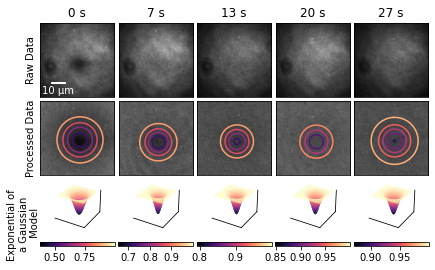

In [17]:
im_indicies = [i*20 for i in range(5)]
cmap=plt.cm.gray
x,y = np.arange(0, 512), np.arange(0, 512) #Define the x and y grid for fitting- as a 2D function need to use meshgrid and later ravel
X, Y = np.meshgrid(x, y)
    
#re-import the raw data for post bleach
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP\Data\2022_03_17\2022_03_17_SLB_TR\plottable\2/'+filename+'/post')
filename_post = 'cropped '+filename+'_MMStack_Pos0.ome.tif'
im_post_raw = io.imread(filename_post)
im_post_raw = im_post_raw.astype(float) #Convert the entries in each array to floats

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


for i in range(5):
    
    ax=plt.subplot(3,5,i+1)
    ax.imshow(im_post_raw[im_indicies[i]],cmap=plt.cm.gray)
    if i == 0:
        ax.set_ylabel('Raw Data')
        scale_bar_size = 10 #in um
        pixel_width =107/1000 #in um
        scalebar = AnchoredSizeBar(ax.transData,
                           scale_bar_size/pixel_width, str(10) +' μm', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=5)
                    
        ax.add_artist(scalebar)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(str(round(df_gauss['Time (s)'][im_indicies[i]]))+' s')

for i in range(5):
    ax=plt.subplot(3,5,i+6)
    Z=np.exp(-df_gauss['Depth'][im_indicies[i]]*np.exp((-2*((X-df_gauss['x0'][im_indicies[i]])**2+(Y-df_gauss['y0'][im_indicies[i]])**2))/(df_gauss['Re'][im_indicies[i]]**2))) #define optimal fit
    ax.imshow(im_post[im_indicies[i]],cmap=plt.cm.gray)
    if i == 0:
        ax.set_ylabel('Processed Data')
    ax.set_xticks([])
    ax.set_yticks([])
    fitted_exp_gauss_contor=ax.contour(X,Y,Z,cmap='magma',zlim=(0,1), levels=4)
    #cb = plt.colorbar(fitted_exp_gauss_contor,location='bottom')


    

for i in range(5):
    ax=plt.subplot(3,5,i+11, projection='3d')
    Z=np.exp(-df_gauss['Depth'][im_indicies[i]]*np.exp((-2*((X-df_gauss['x0'][im_indicies[i]])**2+(Y-df_gauss['y0'][im_indicies[i]])**2))/(df_gauss['Re'][im_indicies[i]]**2))) #define optimal fit
    fitted_exp_gauss_3d = ax.plot_surface(X,Y,Z,cmap='magma',label='Model') 
    plt.colorbar(fitted_exp_gauss_3d,location='bottom')
    

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))


plt.subplots_adjust(left=0.1,
                    bottom=0.05, 
                    right=1, 
                    top=0.85, 
                    wspace=0.05, 
                    hspace=0.05)
plt.gcf().text(0.063, 0.15, 'Exponential of\na Gaussian\n Model',rotation ='vertical',ha='center', va='center')

#plt.tight_layout()
fig.set_size_inches(30, 18)
os.chdir(r'C:\Users\tselb\OneDrive - University of Cambridge\Documents\Mini 2\FRAP')
plt.savefig('big_fig.png',dpi=600)

# Make a animation of recovery

In [6]:
cmap = 'magma'
x,y = np.arange(0, 512), np.arange(0, 512) #Define the x and y grid for fitting- as a 2D function need to use meshgrid and later ravel
X,Y= np.meshgrid(x,y)

good_plots = np.empty((1,1))

for i in range(len(im_post)):
    try:
        fig= plt.figure(figsize=plt.figaspect(0.5))
        ax0,ax1= fig.add_subplot(1, 2, 1),fig.add_subplot(1, 2, 2, projection='3d')
        ax0.imshow(im_post[i],cmap=plt.cm.gray)
        ax0.set_xticks([])
        ax0.set_yticks([])
        Z=np.exp(-df_gauss['Depth'][i]*np.exp((-2*((X-df_gauss['x0'][i])**2+(Y-df_gauss['y0'][i])**2))/(df_gauss['Re'][i]**2))) #define optimal fit
        fitted_exp_gauss_contor= ax0.contour(X,Y,Z,cmap=cmap,zlim=(0,1))
        cb = fig.colorbar(fitted_exp_gauss_contor,location='left')
        fitted_exp_gauss_3d = ax1.plot_surface(X,Y,Z,cmap=cmap,label='Model') 
        fig.colorbar(fitted_exp_gauss_3d,location='bottom')
        plt.savefig(f'{i}.png')
        plt.close()
        good_plots = np.vstack((good_plots,i))
    except:
        pass
    
    
from PIL import Image
np.delete(good_plots,0)
images = [Image.open(good_plots[n]+".png") for n in range(len(good_plots))]
images[0].save(filename_post+'.gif', save_all=True, append_images=images[1:], duration=100, loop=0)


SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' (Temp/ipykernel_1328/3420101123.py, line 28)

In [16]:
images = [Image.open(str(good_plots[n])[1:-2]+".png") for n in range(len(good_plots))]
images[0].save(filename_post+'.gif', save_all=True, append_images=images[1:], duration=100, loop=0)

In [15]:
str(good_plots[0])[1:-2]

'0'